In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-inviter)=
# Inverse iteration

Power iteration finds only the dominant eigenvalue. We next show that it can be adapted to find any eigenvalue, provided you start with a reasonably good estimate of it. Some simple linear algebra is all that is needed.


::::{proof:theorem}
Let $\mathbf{A}$ be an $n\times n$ matrix with eigenvalues $\lambda_1,\ldots,\lambda_n$ (possibly with repeats), and let $s$ be a complex scalar. Then:

1. The eigenvalues of the matrix $\mathbf{A}-s\mathbf{I}$ are $\lambda_1-s,\ldots,\lambda_n-s$.
2. If $s$ is not an eigenvalue of $\mathbf{A}$, the eigenvalues of the matrix $(\mathbf{A}-s\mathbf{I})^{-1}$ are $(\lambda_1-s)^{-1},\ldots,(\lambda_n-s)^{-1}$.
3. The eigenvectors associated with the eigenvalues in the first two parts are the same as those of $\mathbf{A}$.
::::

::::{proof:proof}

The equation $\mathbf{A}\mathbf{v}=\lambda \mathbf{v}$ implies that $(\mathbf{A}-s\mathbf{I})\mathbf{v} = \mathbf{A}\mathbf{v} - s\mathbf{I}\mathbf{v} = \lambda\mathbf{v} - s\mathbf{v} = (\lambda-s)\mathbf{v}$. That proves the first part of the theorem. For the second part, we note that by assumption, $(\mathbf{A}-s\mathbf{I})$ is nonsingular, so $(\mathbf{A}-s\mathbf{I})\mathbf{v} = (\lambda-s) \mathbf{v}$ implies that $\mathbf{v} = (\lambda-s) (\mathbf{A}-s\mathbf{I}) \mathbf{v}$, or $ (\lambda-s)^{-1} \mathbf{v} =(\mathbf{A}-s\mathbf{I})^{-1} \mathbf{v}$. The discussion above also proves the third part of the theorem.
::::


Consider first part 2 of the theorem with $s=0$, and suppose that $\mathbf{A}$ has a *smallest* eigenvalue,

:::{math}
|\lambda_n| \ge |\lambda_{n-1}| \ge \cdots > |\lambda_1|.
:::

Then clearly

:::{math}
|\lambda_1^{-1}| > |\lambda_{2}^{-1}| \ge \cdots \ge |\lambda_n^{-1}|,
:::

```{index} eigenvalue; dominant
```

and $\mathbf{A}^{-1}$ has a dominant eigenvalue. Hence power iteration on $\mathbf{A}^{-1}$ can be used to find the eigenvalue of $\mathbf{A}$ closest to zero. For nonzero values of $s$, then we suppose there is an ordering

:::{math}
:label: shiftorder
|\lambda_n-s| \ge \cdots \ge |\lambda_2-s|  > |\lambda_1-s|.
:::

Then it follows that

:::{math}
|\lambda_1-s|^{-1} > |\lambda_{2}-s|^{-1} \ge \cdots \ge |\lambda_n-s|^{-1},
:::

and power iteration on the matrix $(\mathbf{A}-s\mathbf{I})^{-1}$ converges to $(\lambda_1-s)^{-1}$, which is easily solved for $\lambda_1$ itself.

## Algorithm

A literal application of {numref}`Algorithm {number} <algorithm-power-power>` would include the step 

:::{math}
:label: shiftinvstepbad
\mathbf{y}_k = (\mathbf{A}-s\mathbf{I})^{-1} \mathbf{x}_k.
:::

As always, we do not want to explicitly find the inverse of a matrix. Instead we should write this step as the solution of a linear system.

```{index} ! inverse iteration
```
```{index} see: shifted inverse iteration; inverse iteration
```


(algorithm-inviter-inviter)=
::::{proof:algorithm} Inverse iteration
Given matrix $\mathbf{A}$ and shift $s$:
1. Choose $\mathbf{x}_1$.
2. For $k=1,2,\ldots$, 

    a. Solve for $\mathbf{y}_k$ in
    :::{math}
    :label: shiftinvstep
    (\mathbf{A}-s\mathbf{I}) \mathbf{y}_k =\mathbf{x}_k .
    :::

    b. Find $m$ such that $|y_{k,m}|=\|{\mathbf{y}_k} \|_\infty$.

    c. Set $\alpha_k = \dfrac{1}{y_{k,m}}$ and $\,\beta_k = s + \dfrac{x_{k,m}}{y_{k,m}}$.

    d. Set $\mathbf{x}_{k+1} = \alpha_k \mathbf{y}_k$.
::::

Note that in {numref}`Algorithm {number} <algorithm-power-power>`, we used $y_{k,m}/x_{k,m}$ as an estimate of the dominant eigenvalue of $\mathbf{A}$. Here, that ratio is an estimate of $(\lambda_1-s)^{-1}$, and solving for $\lambda_1$ gives the $\beta_k$ in {numref}`Algorithm {number} <algorithm-inviter-inviter>`.

Each pass of inverse iteration requires the solution of a linear system of equations with the matrix $\mathbf{B}=\mathbf{A}-s\mathbf{I}$. This solution might use methods we consider later in this chapter. Here, we use (sparse) PLU factorization and hope for the best. Since the matrix $\mathbf{B}$ is constant, the factorization needs to be done only once for all iterations. The details are in {numref}`Function {number} <function-inviter>`.

(function-inviter)=
````{proof:function} inviter
**Shifted inverse iteration for the closest eigenvalue**

```{code-block} julia1
:lineno-start: 1
"""
    inviter(A,s,numiter)

Perform `numiter` inverse iterations with the matrix `A` and shift
`s`, starting from a random vector. Returns a vector of
eigenvalue estimates and the final eigenvector approximation.
"""
function inviter(A,s,numiter)
    n = size(A,1)
    x = normalize(randn(n),Inf)
    β = zeros(numiter)
    fact = lu(A - s*I)
    for k in 1:numiter
        y = fact\x
        normy,m = findmax(abs.(y))
        β[k] = x[m]/y[m] + s
        x = y/y[m]
    end
    return β,x
end
```
````
## Convergence

The convergence is linear, at a rate found by reinterpreting {eq}`poweriterconv` with $(\mathbf{A}-s\mathbf{I})^{-1}$ in place of $\mathbf{A}$:

:::{math}
:label: inviterconv
\frac{\beta_{k+1} - \lambda_1}{\beta_{k} - \lambda_1} \rightarrow
\frac{  \lambda_1 - s } {\lambda_2 - s}\quad \text{ as } \quad k\rightarrow \infty,
:::

with the eigenvalues ordered as in {eq}`shiftorder`. Thus, the convergence is best when the shift $s$ is close to the target eigenvalue $\lambda_1$, specifically when it is much closer to that eigenvalue than to any other.

(demo-inviter-conv)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We set up a $5\times 5$ triangular matrix with prescribed eigenvalues on its diagonal.

In [2]:
λ = [1,-0.75,0.6,-0.4,0]
# Make a triangular matrix with eigenvalues on the diagonal.
A = triu(ones(5,5),1) + diagm(λ)

5×5 Matrix{Float64}:
 1.0   1.0   1.0   1.0  1.0
 0.0  -0.75  1.0   1.0  1.0
 0.0   0.0   0.6   1.0  1.0
 0.0   0.0   0.0  -0.4  1.0
 0.0   0.0   0.0   0.0  0.0

We run inverse iteration with the shift $s=0.7$ and take the final estimate as our "exact" answer to observe the convergence.

In [3]:
s = 0.7
β,x = FNC.inviter(A,s,30)
eigval = β[end]

0.5999999999999984

As expected, the eigenvalue that was found is the one closest to 0.7. The convergence is again linear.

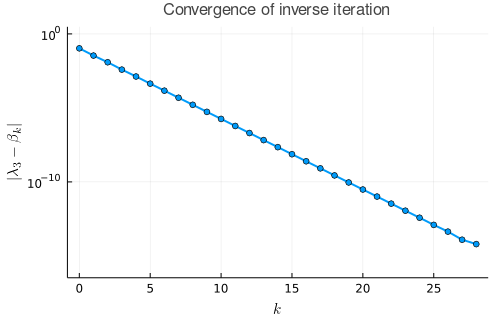

In [4]:
err = @. abs(eigval-β)
plot(0:28,err[1:end-1],m=:o,
    title="Convergence of inverse iteration",
    xlabel=L"k",yaxis=(L"|\lambda_3-\beta_k|",:log10,[1e-16,1]))

The observed linear convergence rate is found from the data.

In [5]:
@show observed_rate = err[22]/err[21];

observed_rate = err[22] / err[21] = 0.33326532173735623


```{index} ! Julia; sortperm
```

::::{panels}
:column: col-7 left-side
:card: border-0 shadow-none
```{raw} latex
\begin{minipage}[t]{0.5\textwidth}
```
We reorder the eigenvalues to enforce {eq}`shiftorder`. 

```{raw} latex
\end{minipage}\hfill
```
---
:column: col-5 right-side
:card: shadow-none comment
```{raw} latex
\begin{minipage}[t]{0.4\textwidth}\begin{mdframed}[default]\small
```
The `sortperm` function returns the index permutation needed to sort the given vector, rather than the sorted vector itself.
```{raw} latex
\end{mdframed}\end{minipage}
```
::::

In [6]:
λ = λ[ sortperm(abs.(λ.-s)) ]

5-element Vector{Float64}:
  0.6
  1.0
  0.0
 -0.4
 -0.75

Hence the theoretical convergence rate is

In [7]:
@show theoretical_rate = (λ[1]-s) / (λ[2]-s);

theoretical_rate = (λ[1] - s) / (λ[2] - s) = -0.3333333333333332


```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```


## Dynamic shifting

There is a clear opportunity for positive feedback in {numref}`Algorithm {number} <algorithm-inviter-inviter>`. The convergence rate of inverse iteration improves as the shift gets closer to the true eigenvalue—and the algorithm computes improving eigenvalue estimates! If we update the shift to $s=\beta_k$ after each iteration, the convergence accelerates. You are asked to implement this algorithm in {ref}`Exercise 6 <problem-inviter-dynamicshift>`.

```{index} convergence rate; quadratic
```

Let's analyze the resulting convergence. If the eigenvalues are ordered by distance to $s$, then the convergence is linear with rate $|\lambda_1-s|/|\lambda_2-s|$. As $s\to\lambda_1$, the change in the denominator is negligible. So if the error $(\lambda_1-s)$ is $\epsilon$, then the error in the next estimate is reduced by a factor $O(\epsilon)$. That is, $\epsilon$ becomes $O(\epsilon^2)$, which is *quadratic* convergence.

(demo-inviter-accel)=
:::{proof:demo}
:::

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

In [8]:
λ = [1,-0.75,0.6,-0.4,0]
# Make a triangular matrix with eigenvalues on the diagonal.
A = triu(ones(5,5),1) + diagm(λ) 

5×5 Matrix{Float64}:
 1.0   1.0   1.0   1.0  1.0
 0.0  -0.75  1.0   1.0  1.0
 0.0   0.0   0.6   1.0  1.0
 0.0   0.0   0.0  -0.4  1.0
 0.0   0.0   0.0   0.0  0.0

We begin with a shift $s=0.7$, which is closest to the eigenvalue 0.6.

In [9]:
s = 0.7
x = ones(5)
y = (A-s*I)\x
β = x[1]/y[1] + s

0.7034813925570228

Note that the result is not yet any closer to the targeted 0.6. But we proceed (without being too picky about normalization here).

In [10]:
s = β
x = y/y[1]
y = (A-s*I)\x
β = x[1]/y[1] + s

0.5612761406172997

Still not much apparent progress. However, in just a few more iterations the results are dramatically better.

In [11]:
for k in 1:4
    s = β  
    x = y/y[1]
    y = (A-s*I)\x  
    @show β = x[1]/y[1] + s
end

β = x[1] / y[1] + s = 0.5964312884753865
β = x[1] / y[1] + s = 0.5999717091820104
β = x[1] / y[1] + s = 0.5999999978556353
β = x[1] / y[1] + s = 0.6


```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

There is a price to pay for this improvement. The matrix of the linear system to be solved, $(\mathbf{A}-s\mathbf{I})$, now changes with each iteration. That means that we can no longer do just one LU factorization for the entire iteration. The speedup in convergence usually makes this tradeoff worthwhile, however.

In practice power and inverse iteration are not as effective as the algorithms used by `eigs` and based on the mathematics described in the rest of this chapter. However, inverse iteration can be useful for turning an eigenvalue estimate into an eigenvector estimate.

## Exercises

(problem-invitercomp)=
1. ⌨  Use {numref}`Function {number} <function-inviter>` to perform 10 iterations for the given matrix and shift. Compare the results quantitatively to the convergence given by {eq}`inviterconv`.
  
    **(a)**  $\mathbf{A} = \begin{bmatrix}
        1.1 & 1 \\
        0 & 2.1
      \end{bmatrix}, \; s = 1 \qquad $
    **(b)** $\mathbf{A} = \begin{bmatrix}
        1.1 & 1 \\
        0 & 2.1
      \end{bmatrix}, \; s = 2\qquad $
    
    **(c)** $\mathbf{A} = \begin{bmatrix}
        1.1 & 1 \\
        0 & 2.1
      \end{bmatrix}, \; s = 1.6\qquad $
    **(d)** $\mathbf{A} = \begin{bmatrix}
        2 & 1 \\
        1 & 0
      \end{bmatrix}, \; s = -0.33 \qquad$

    **(e)** $\mathbf{A} = \begin{bmatrix}
      6 & 5 & 4 \\
      5 & 4 & 3 \\
      4 & 3 & 2
    \end{bmatrix}, \;  s = 0.1 $
      
2. ✍ Let $\mathbf{A} = \displaystyle \begin{bmatrix} 1.1 & 1 \\ 0 & 2.1 \end{bmatrix}.$ Given the starting vector $\mathbf{x}_1=[1,1]$, find the vector $\mathbf{x}_2$ for the following shifts.
    
    **(a)** $s=1\quad$ **(b)** $s=2\quad$ **(c)** $s=1.6$

3. ✍ Why is it a bad idea to use unshifted inverse iteration with the matrix $\displaystyle \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}$? Does the shift $s=-1$ improve matters?

4. ✍ When the shift $s$ is very close to an eigenvalue of $\mathbf{A}$, the matrix $\mathbf{A}-s\mathbf{I}$ is close to a singular matrix. But then {eq}`shiftinvstep` is a linear system with a badly conditioned matrix, which should create a lot of error in the numerical solution for $\mathbf{y}_k$. However, it happens that the error is mostly in the direction of the eigenvector we are looking for, as the following toy example illustrates.

    Prove that $\displaystyle \begin{bmatrix} 1 & 1 \\ 0 & 0 \end{bmatrix}$ has an eigenvalue at zero with associated eigenvector $\mathbf{v}=[-1,1]^T$. Suppose this matrix is perturbed slightly to $\displaystyle \mathbf{A} = \begin{bmatrix} 1 & 1 \\ 0 & \epsilon \end{bmatrix}$, and that $\mathbf{x}_k=[1,1]$ in {eq}`shiftinvstep`. Show that once $\mathbf{y}_k$ is normalized by its infinity norm, the result is within $\epsilon$ of a multiple of $\mathbf{v}$.

    % must stay as #5
    (problem-inviter-lumpmembraneinveig)=
5. ⌨ (Continuation of [Exercise 8.2.3](problem-power-lumpmembraneeig).) This exercise concerns the $n^2\times n^2$ sparse matrix defined by `FNC.poisson(n)` for integer $n$. It represents a lumped model of a vibrating square membrane held fixed around the edges.

    **(a)** The eigenvalues of $\mathbf{A}$ closest to zero are approximately squares of the frequencies of vibration for the membrane. Using `eigs`, find the eigenvalue $\lambda_m$ closest to zero for $n=10,15,20,25$.
    
    **(b)** For each $n$ in part (a), apply 50 steps of {numref}`Function {number} <function-inviter>` with zero shift. On one graph, plot the four convergence curves $|\beta_k-\lambda_m|$ using a semi-log scale.

    **(c)** Let `v` be the eigenvector (second output) found by {numref}`Function {number} <function-inviter>` for $n=25$. Visualize the vibration mode of the membrane using 
    
    ```julia
    surface(reshape(v,n,n))
    ```
    
    % must remain as number 6
    (problem-inviter-dynamicshift)=
6. ⌨ This problem explores the use of dynamic shifting to accelerate the inverse iteration.
  
    **(a)** Modify {numref}`Function {number} <function-inviter>` to change the value of the shift $s$ to be the most recently computed value in the vector $\beta$. Note that the matrix `B` must also change with each iteration, and the LU factorization cannot be done just once.

    **(b)** Define a matrix with eigenvalues at $k^2$ for $k=1,\ldots,100$ via
    
    ```julia
    A = diagm(0=>(1:100).^2,1=>rand(99))
    ```

    Using an initial shift of $s=920$, apply the dynamic inverse iteration. Determine which eigenvalue was found and make a table of the `log10` of the errors in the iteration as a function of iteration number. (These should approximately double, until machine precision is reached, due to quadratic convergence.)
  
    **(c)** Repeat part (b) using a different initial shift of your choice.